# TOPIC MODELING(using LDA) AND VECTORIZATION 

> **AUTHOR**: RITIKA GUPTA<br>
**OBJECTIVE** : In this notebook we try to do topic modeling using one of the ebooks from Gutenburg Repository.
https://www.gutenberg.org/ebooks/search/?sort_order=downloads&start_index=51
We have chosen the book "Hounds Of Baskervilles" https://www.gutenberg.org/ebooks/2852 for the purpose of topic modeling and trying to find what are the major topics in the book.<br>

> **METHODS** : Following 

* Vectorization Techniques : BOW,TF-IDF
* Unsupervised Topic Modelling using LDA,NMF , LSI







In [41]:
import pandas as pd
#---------reading data
import urllib

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
import gensim.downloader as gensim_api

## Load Data
Use url of plain text "UTF-8" for the particular book to avoid pictures and have text only ebook

In [2]:
#Use url of plain text "UTF-8" for the particular book
url="https://www.gutenberg.org/files/2852/2852-0.txt"

#Custom function to read the book from url using URLLIB package
def load_gutenberg(target_url): 
  book= open('book_hounds.txt','w+')
  
  for line in urllib.request.urlopen(target_url):
    read_line=line.decode('utf-8')
    book.write(read_line) #write book in text file


In [7]:
#write txt
load_gutenberg(url)

#reading a part of book to check if write was successful
start_index=0
end_index=900
with open("book_hounds.txt") as file:
  file.seek(start_index)
  data = file.read(end_index - start_index)

print(data)

﻿The Project Gutenberg eBook of The Hound of the Baskervilles, by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Hound of the Baskervilles

Author: Arthur Conan Doyle

Release Date: October, 2001 [eBook #2852]
[Most recently updated: June 27, 2021]

Language: English

Character set encoding: UTF-8

Produced by: Shreevatsa R, and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK THE HOUND OF THE BASKERVILLES ***

cover 



THE HOUND OF THE BASKERVILLES

Another Ad


## Preprocess

In [4]:
# Preprocessor :  removing stopwords, stemming, lemmatization
import gensim
from gensim.utils import simple_preprocess   
from gensim.parsing.preprocessing import STOPWORDS

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, SnowballStemmer    
    
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))  # pos = "v" => only lemmatize verbs and leave nouns 'n' and adjectives 'a' alone
def preprocess(text):
    token_list = []
    for token in gensim.utils.simple_preprocess(text,min_len=4): # Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            token_list.append(lemmatize_stemming(token))
    #cleaned_line=" ".join(token_list)
    return token_list #nltk.tokenize.word_tokenize(token_list)

# Function to read file and convert each line of file as preprocessed tokens
def clean_text(data_path): 
  summaries = []  
  for line in open(data_path, encoding="utf-8"):
    summaries.append(preprocess(line))
  #Removing documents which have zero length  
  summaries=[line for line in summaries if len(line)>0]
  return summaries

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
data_path = "/content/book_hounds.txt"

#Calling custom function for cleaning and each line of text and converting each line to a document
#This function returns list of lines and each line as list of words(tokens)

summaries=clean_text(data_path)
print(summaries)


[['project', 'gutenberg', 'ebook', 'hound', 'baskervill', 'arthur', 'conan', 'doyl'], ['ebook', 'unit', 'state'], ['part', 'world', 'cost', 'restrict'], ['whatsoev', 'copi', 'away', 'term'], ['project', 'gutenberg', 'licens', 'includ', 'ebook', 'onlin'], ['gutenberg', 'locat', 'unit', 'state'], ['check', 'law', 'countri', 'locat'], ['ebook'], ['titl', 'hound', 'baskervill'], ['author', 'arthur', 'conan', 'doyl'], ['releas', 'date', 'octob', 'ebook'], ['recent', 'updat', 'june'], ['languag', 'english'], ['charact', 'encod'], ['produc', 'shreevatsa', 'david', 'widger'], ['start', 'project', 'gutenberg', 'ebook', 'hound', 'baskervill'], ['cover'], ['hound', 'baskervill'], ['adventur', 'sherlock', 'holm'], ['conan', 'doyl'], ['dear', 'robinson'], ['account', 'west', 'countri', 'legend', 'tale', 'owe'], ['incept', 'help', 'detail', 'thank'], ['truli'], ['conan', 'doyl'], ['hindhead'], ['haslemer'], ['content'], ['chapter', 'sherlock', 'holm'], ['chapter', 'curs', 'baskervill'], ['chapter', 

# Preprocess , Vetorization and Unsupervised Topic Modeling

* Vectorizer  : CountVectorizer & Tf-IDF
* Unsupervised Model : LDA , NMF & LSI (truncated SVD)

In [ ]:
global lda_model
global nmf_model
global lsi_model

In [11]:
# function for Pre-processing, Vectorizing & Modeling
def topic_classifier(text, vectorizer_method, model, n_components=10, top_n=8):
    """
    >>> text: Plain Text UTF-8 format
    >>> vectorizer_method: One of two sklearn vectorizors: TfidfVectorizer, CountVectorizer
    >>> model: One of three sklearn topic classifiers: LDA, NMF, LSI
    >>> n_components: Number of topics for modeling
    >>> top_n: Number of words to see in each topic result
    """
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
    
    
    # pre-process: removing stopwords, stemming, lemmatization
    import gensim
    from gensim.utils import simple_preprocess   # Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
    from gensim.parsing.preprocessing import STOPWORDS
    import nltk
    from nltk.stem import WordNetLemmatizer, SnowballStemmer
    stemmer = SnowballStemmer('english')
    def lemmatize_stemming(text):
        return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))  # pos = "v" => only lemmatize verbs and leave nouns 'n' and adjectives 'a' alone
    def preprocess(text):
        token_list = []
        for token in gensim.utils.simple_preprocess(text):
            if token not in gensim.parsing.preprocessing.STOPWORDS:
                token_list.append(lemmatize_stemming(token))
        return token_list
    
    
    # vectorizing
    if str(vectorizer_method).lower() == 'countvectorizer':
        print('=== Topic classifying using CountVectorizer ===\n')
        vectorizer = CountVectorizer(min_df=5,                                     # minimum reqd occurences of a word
                                     max_df=0.9,
                                     stop_words='english',                         # remove stop words
                                     lowercase=True,                               # convert all words to lowercase
                                     token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')     # num chars > 2
    else:
        print('=== Topic classifying using TfidfVectorizer ===\n')
        vectorizer = TfidfVectorizer(min_df=5,
                                     max_df=0.9,
                                     stop_words='english',
                                     lowercase=True,
                                     token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
    # we will call our function "preprocess" for the fit_transform
    # We also need to "open" the text file and "read" it -> open(text).read()
    data_vectorized = vectorizer.fit_transform(preprocess(open(text).read()))
    
    
    # custom function for inspecting the topics result of our modeling
    def print_topics(model, vectorizer, top_n=top_n):
        for idx, topic in enumerate(model.components_):
            print("Topic %d:" % (idx))
            print([(vectorizer.get_feature_names()[i], topic[i].round(6))
                   for i in topic.argsort()[:-top_n - 1:-1]])
    
    
    # modeling (LDA, NMF, LSI)
    from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
    if str(model).lower() == 'lda':
        # Build a Latent Dirichlet Allocation Model
        global lda_model

        lda_model = LatentDirichletAllocation(n_components=n_components, max_iter=10, learning_method='online')    # n_components = no. of topics
        lda_fit_cnt_v = lda_model.fit_transform(data_vectorized)
        print(f'LDA No. of Docs & No. of Topics: {lda_fit_cnt_v.shape}\n')
        # print topics
        print(f'Top {n_components} LDA topics with top {top_n} words in each topic:\n')
        print_topics(lda_model, vectorizer)
    
    elif str(model).lower() == 'nmf':
        # Build a Non-Negative Matrix Factorization Model
        # with random init, the results can be different every time; 
        # More reliable results can be obtained if you initialise with SVD (Belford et al, 2018).
        global nmf_model
        nmf_model = NMF(n_components=n_components, init="nndsvd")   
        nmf_fit_cnt_v = nmf_model.fit_transform(data_vectorized)
        print(f'NMF No. of Docs & No. of Topics: {nmf_fit_cnt_v.shape}\n')
        # print topics
        print(f'Top {n_components} NMF topics with top {top_n} words in each topic:\n')
        print_topics(nmf_model, vectorizer)
    
    else:
        # Build a truncated SVD (aka LSI: Latent Semantic Indexing) Model
        global lsi_model
        lsi_model = TruncatedSVD(n_components=n_components)
        lsi_fit_cnt_v = lsi_model.fit_transform(data_vectorized)
        print(f'LSI No. of Docs & No. of Topics: {lsi_fit_cnt_v.shape}\n')
        # print topics
        print(f'Top {n_components} LSI topics with top {top_n} words in each topic:\n')
        print_topics(lsi_model, vectorizer)

    return preprocess

# Generate Topics Models

In [18]:
topic_classifier('book_hounds.txt', 'countvectorizer', 'LDA', 5, 10)

=== Topic classifying using CountVectorizer ===

LDA No. of Docs & No. of Topics: (23797, 5)

Top 5 LDA topics with top 10 words in each topic:

Topic 0:
[('gutenberg', 143.230543), ('work', 141.636621), ('look', 88.465115), ('case', 84.760372), ('day', 78.486169), ('hous', 77.044243), ('barrymor', 72.45834), ('like', 64.205079), ('place', 59.203747), ('run', 56.00724)]
Topic 1:
[('sir', 327.891883), ('say', 223.094085), ('henri', 153.717582), ('think', 132.663067), ('face', 93.042418), ('hound', 87.630673), ('hand', 83.554687), ('way', 74.256066), ('ask', 67.128636), ('turn', 60.972302)]
Topic 2:
[('project', 133.549386), ('baskervill', 112.442438), ('charl', 84.696949), ('long', 70.232239), ('away', 64.033666), ('yes', 53.171479), ('great', 51.670639), ('walk', 51.655111), ('word', 51.520592), ('matter', 50.175287)]
Topic 3:
[('come', 188.847395), ('know', 184.626668), ('holm', 179.676038), ('moor', 157.012341), ('stapleton', 123.482289), ('tell', 114.666639), ('watson', 110.185485),

<function __main__.topic_classifier.<locals>.preprocess>

In [13]:
topic_classifier('book_hounds.txt', 'countvectorizer', 'NMF', 5, 10)

=== Topic classifying using CountVectorizer ===

NMF No. of Docs & No. of Topics: (23797, 5)

Top 5 NMF topics with top 10 words in each topic:

Topic 0:
[('sir', 4.328394), ('henri', 0.0), ('think', 0.0), ('baskervill', 0.0), ('tell', 0.0), ('work', 0.0), ('stapleton', 0.0), ('watson', 0.0), ('gutenberg', 0.0), ('charl', 0.0)]
Topic 1:
[('say', 3.960351), ('henri', 0.0), ('think', 0.0), ('watson', 0.0), ('work', 0.0), ('tell', 0.0), ('stapleton', 0.0), ('gutenberg', 0.0), ('face', 0.0), ('mortim', 0.0)]
Topic 2:
[('man', 3.824741), ('henri', 0.0), ('think', 0.0), ('watson', 0.0), ('stapleton', 0.0), ('work', 0.0), ('face', 0.0), ('project', 0.0), ('hear', 0.0), ('look', 0.0)]
Topic 3:
[('holm', 3.736843), ('henri', 7e-06), ('think', 0.0), ('watson', 0.0), ('tell', 0.0), ('work', 0.0), ('charl', 0.0), ('face', 0.0), ('look', 0.0), ('day', 0.0)]
Topic 4:
[('come', 3.727246), ('henri', 1.7e-05), ('think', 1e-06), ('watson', 0.0), ('work', 0.0), ('stapleton', 0.0), ('face', 0.0), ('hear',

In [14]:
topic_classifier('book_hounds.txt', 'countvectorizer', 'LSI', 5, 10)

=== Topic classifying using CountVectorizer ===

LSI No. of Docs & No. of Topics: (23797, 5)

Top 5 LSI topics with top 10 words in each topic:

Topic 0:
[('sir', 1.0), ('mortim', 0.000205), ('tell', 0.000198), ('hear', 9.6e-05), ('think', 6.8e-05), ('charl', 4.4e-05), ('death', 4.4e-05), ('day', 4.3e-05), ('moor', 3.7e-05), ('case', 3e-05)]
Topic 1:
[('say', 0.999932), ('gutenberg', 0.005515), ('work', 0.004267), ('henri', 0.003374), ('time', 0.003259), ('stapleton', 0.002361), ('watson', 0.001629), ('come', 0.001468), ('barrymor', 0.001347), ('face', 0.001301)]
Topic 2:
[('man', 0.999629), ('gutenberg', 0.012418), ('stapleton', 0.009499), ('henri', 0.009014), ('work', 0.007061), ('come', 0.005873), ('watson', 0.005397), ('know', 0.00383), ('mortim', 0.003666), ('say', 0.00164)]
Topic 3:
[('holm', 0.999606), ('come', 0.013277), ('eye', 0.007747), ('work', 0.007711), ('know', 0.005774), ('watson', 0.005469), ('hound', 0.004436), ('stapleton', 0.004207), ('hous', 0.003097), ('project', 

# Evaluate Models Using Coherence

In [13]:
scores = {"Model":[],"Vectorizer":[],"Coherence_Scores":[]}

In [12]:
# Fetching token list using python closures 
token_list_func = topic_classifier('book_hounds.txt', 'tfidf', 'NMF', 5, 10)
token_list = token_list_func(open('book_hounds.txt').read())

=== Topic classifying using TfidfVectorizer ===

NMF No. of Docs & No. of Topics: (23794, 5)

Top 5 NMF topics with top 10 words in each topic:

Topic 0:
[('sir', 4.328394), ('know', 0.0), ('henri', 0.0), ('think', 0.0), ('baskervill', 0.0), ('watson', 0.0), ('tell', 0.0), ('stapleton', 0.0), ('work', 0.0), ('gutenberg', 0.0)]
Topic 1:
[('say', 3.960351), ('know', 0.0), ('moor', 0.0), ('baskervill', 0.0), ('tell', 0.0), ('stapleton', 0.0), ('gutenberg', 0.0), ('charl', 0.0), ('work', 0.0), ('look', 0.0)]
Topic 2:
[('man', 3.824724), ('know', 2.1e-05), ('think', 0.0), ('tell', 0.0), ('stapleton', 0.0), ('gutenberg', 0.0), ('face', 0.0), ('hear', 0.0), ('hound', 0.0), ('night', 0.0)]
Topic 3:
[('holm', 3.73687), ('moor', 4e-06), ('baskervill', 0.0), ('henri', 0.0), ('work', 0.0), ('watson', 0.0), ('stapleton', 0.0), ('look', 0.0), ('project', 0.0), ('face', 0.0)]
Topic 4:
[('come', 3.72723), ('moor', 1.2e-05), ('baskervill', 0.0), ('work', 0.0), ('stapleton', 0.0), ('project', 0.0), ('ch

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
token_list[:10]

['project',
 'gutenberg',
 'ebook',
 'hound',
 'baskervill',
 'arthur',
 'conan',
 'doyl',
 'ebook',
 'use']

In [60]:
!pip install gensim==4.0

     |████████████████████████████████| 23.9 MB 2.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [14]:
#Building  Dictionary and Corpus 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import LsiModel

id2word = corpora.Dictionary([token_list])
print(type(id2word))
print()
print(id2word)




<class 'gensim.corpora.dictionary.Dictionary'>

Dictionary(3773 unique tokens: ['aback', 'abandon', 'abet', 'abhor', 'abid']...)


## BOW CORPUS and Evaluation

In [15]:
# Create Bag Of Words Corpus
corpus = [id2word.doc2bow(text) for text in [token_list]]   # corpus is a list of one list
print('\n',corpus[0][0:100])


 [(0, 1), (1, 7), (2, 1), (3, 1), (4, 4), (5, 3), (6, 27), (7, 1), (8, 1), (9, 4), (10, 7), (11, 3), (12, 3), (13, 1), (14, 2), (15, 1), (16, 2), (17, 10), (18, 12), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 6), (25, 13), (26, 2), (27, 2), (28, 1), (29, 6), (30, 8), (31, 1), (32, 1), (33, 11), (34, 10), (35, 9), (36, 8), (37, 2), (38, 8), (39, 6), (40, 13), (41, 1), (42, 1), (43, 9), (44, 1), (45, 3), (46, 1), (47, 2), (48, 2), (49, 5), (50, 12), (51, 6), (52, 5), (53, 21), (54, 3), (55, 1), (56, 1), (57, 4), (58, 1), (59, 2), (60, 6), (61, 1), (62, 1), (63, 9), (64, 5), (65, 9), (66, 1), (67, 1), (68, 3), (69, 6), (70, 2), (71, 2), (72, 14), (73, 18), (74, 5), (75, 2), (76, 8), (77, 1), (78, 17), (79, 5), (80, 5), (81, 1), (82, 6), (83, 16), (84, 2), (85, 11), (86, 1), (87, 1), (88, 3), (89, 2), (90, 6), (91, 3), (92, 1), (93, 1), (94, 10), (95, 1), (96, 2), (97, 6), (98, 2), (99, 5)]


In [16]:
#Custom Function Using Coherence Model of Gensim for Model Evaluation

def eval_topic_model(model,token_list,id2word):
  coherence_model = CoherenceModel(model=model, texts=[token_list], dictionary=id2word, coherence='c_v')
  coherence = coherence_model.get_coherence()
  print('\nCoherence Score: ', coherence.round(3))
  return coherence.round(3)

### LDA + BOW

In [17]:
#Score for LDA BOW MODEL
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            chunksize=200) # chunksize controls how many documents are processed 
                                                                #at a time in the training algorithm. Increasing it will speed up training

print('=== weight*word for each topic ===\n')
for idx, topic in lda_model.print_topics(num_words=8):
    print(f'Topic{idx}: {topic}')

=== weight*word for each topic ===

Topic0: 0.016*"sir" + 0.013*"say" + 0.007*"come" + 0.007*"moor" + 0.007*"henri" + 0.007*"man" + 0.006*"know" + 0.005*"think"
Topic1: 0.017*"sir" + 0.008*"know" + 0.008*"man" + 0.008*"say" + 0.007*"holm" + 0.007*"come" + 0.006*"moor" + 0.005*"henri"
Topic2: 0.012*"sir" + 0.007*"say" + 0.006*"know" + 0.006*"man" + 0.006*"think" + 0.005*"come" + 0.005*"henri" + 0.005*"holm"
Topic3: 0.009*"say" + 0.009*"holm" + 0.008*"sir" + 0.008*"know" + 0.007*"man" + 0.006*"moor" + 0.006*"henri" + 0.006*"come"
Topic4: 0.012*"sir" + 0.009*"say" + 0.008*"henri" + 0.007*"come" + 0.007*"man" + 0.007*"know" + 0.006*"holm" + 0.006*"watson"
Topic5: 0.010*"sir" + 0.010*"holm" + 0.007*"say" + 0.007*"man" + 0.007*"know" + 0.007*"come" + 0.006*"moor" + 0.005*"think"
Topic6: 0.016*"sir" + 0.008*"say" + 0.007*"come" + 0.006*"henri" + 0.006*"moor" + 0.006*"holm" + 0.006*"baskervill" + 0.005*"think"
Topic7: 0.013*"man" + 0.011*"sir" + 0.009*"say" + 0.008*"holm" + 0.007*"come" + 0.00

In [18]:
#Score
scores['Coherence_Scores'].append(eval_topic_model(lda_model,token_list,id2word))
scores['Model'].append("LDA")
scores['Vectorizer'].append("BOW")


Coherence Score:  0.396


### NMF + BOW

In [19]:
nmf_model = GensimNmf(corpus=corpus,
                      id2word=id2word,
                      num_topics=10,
                      chunksize=200)

print('=== weight*word for each topic ===\n')
for idx, topic in nmf_model.print_topics(num_words=8):
    print(f'Topic{idx}: {topic}')

=== weight*word for each topic ===

Topic0: 0.001*"rigid" + 0.001*"regenc" + 0.001*"ideal" + 0.001*"pride" + 0.001*"articul" + 0.001*"farm" + 0.001*"engag" + 0.001*"tuft"
Topic1: 0.015*"sir" + 0.010*"say" + 0.009*"man" + 0.008*"holm" + 0.008*"come" + 0.008*"know" + 0.007*"moor" + 0.007*"henri"
Topic2: 0.015*"sir" + 0.010*"say" + 0.009*"man" + 0.008*"holm" + 0.008*"come" + 0.008*"know" + 0.007*"moor" + 0.007*"henri"
Topic3: 0.015*"sir" + 0.010*"say" + 0.009*"man" + 0.008*"holm" + 0.008*"come" + 0.008*"know" + 0.007*"moor" + 0.007*"henri"
Topic4: 0.015*"sir" + 0.010*"say" + 0.009*"man" + 0.008*"holm" + 0.008*"come" + 0.008*"know" + 0.007*"moor" + 0.007*"henri"
Topic5: 0.013*"sir" + 0.009*"say" + 0.008*"man" + 0.007*"come" + 0.007*"holm" + 0.007*"know" + 0.006*"moor" + 0.006*"henri"
Topic6: 0.015*"sir" + 0.010*"say" + 0.009*"man" + 0.008*"holm" + 0.008*"come" + 0.008*"know" + 0.007*"moor" + 0.007*"henri"
Topic7: 0.001*"scion" + 0.001*"lattic" + 0.001*"examin" + 0.001*"clerk" + 0.001*"flic

In [20]:
#Score
scores['Coherence_Scores'].append(eval_topic_model(nmf_model,token_list,id2word))
scores['Model'].append("NMF")
scores['Vectorizer'].append("BOW")


Coherence Score:  0.495


In [21]:
scores

{'Coherence_Scores': [0.396, 0.495],
 'Model': ['LDA', 'NMF'],
 'Vectorizer': ['BOW', 'BOW']}

### LSI+BOW

In [22]:
lsi_model = gensim.models.lsimodel.LsiModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=10,
            chunksize=200)

In [23]:
#Score
scores['Coherence_Scores'].append(eval_topic_model(lsi_model,token_list,id2word))
scores['Model'].append("LSI")
scores['Vectorizer'].append("BOW")


Coherence Score:  0.371


## TFIDF Corpus And Evaluation

In [24]:
from gensim import models

#Create TF-IDF Vectors
tfidf = models.TfidfModel(corpus)
# Apply TF-IDF model
corpus_tfidf = tfidf[corpus]

### LDA + TF-IDF

In [25]:
#Score for LDA TF-IDF MODEL
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                            id2word=id2word,
                                            num_topics=10,
                                            chunksize=200) # chunksize controls how many documents are processed 
                                                                #at a time in the training algorithm. Increasing it will speed up training

print('=== weight*word for each topic ===\n')
for idx, topic in lda_model.print_topics(num_words=8):
    print(f'Topic{idx}: {topic}')

=== weight*word for each topic ===

Topic0: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettili" + 0.000*"pretti" + 0.000*"pretext" + 0.000*"pretend" + 0.000*"previous" + 0.000*"present"
Topic1: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettili" + 0.000*"pretti" + 0.000*"pretext" + 0.000*"pretend" + 0.000*"previous" + 0.000*"present"
Topic2: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettili" + 0.000*"pretti" + 0.000*"pretext" + 0.000*"pretend" + 0.000*"previous" + 0.000*"present"
Topic3: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettili" + 0.000*"pretti" + 0.000*"pretext" + 0.000*"pretend" + 0.000*"previous" + 0.000*"present"
Topic4: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettili" + 0.000*"pretti" + 0.000*"pretext" + 0.000*"pretend" + 0.000*"previous" + 0.000*"present"
Topic5: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettili" + 0.000*"pretti" + 0.000*"pretext" + 0.000*"pretend" + 0.000*"previous" + 0.000*"present"
Topic6: 0.000*"presumpt" + 0.000*"presum" + 0.000*"prettil

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:835: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [26]:
#Score
scores['Coherence_Scores'].append(eval_topic_model(lda_model,token_list,id2word))
scores['Model'].append("LDA")
scores['Vectorizer'].append("TF-IDF")


Coherence Score:  0.668


### NMF + TF-IDF

In [30]:
nmf_model = GensimNmf(corpus=corpus_tfidf,
                      id2word=id2word,
                      num_topics=10,
                      chunksize=200)

print('=== weight*word for each topic ===\n')
for idx, topic in nmf_model.print_topics(num_words=8):
    print(f'Topic{idx}: {topic}')

/usr/local/lib/python3.7/dist-packages/gensim/models/nmf.py:238: RuntimeWarning: invalid value encountered in true_divide
  return dense_topics / dense_topics.sum(axis=1).reshape(-1, 1)
/usr/local/lib/python3.7/dist-packages/gensim/models/nmf.py:678: RuntimeWarning: divide by zero encountered in double_scalars
  eta = self._kappa / np.linalg.norm(self.A)
/usr/local/lib/python3.7/dist-packages/gensim/models/nmf.py:685: RuntimeWarning: invalid value encountered in multiply
  self._W -= eta * (WA - self.B)


=== weight*word for each topic ===

Topic0: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic1: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic2: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic3: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic4: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic5: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic6: nan*"presumpt" + nan*"presum" + nan*"prettili" + nan*"pretti" + nan*"pretext" + nan*"pretend" + nan*"previous" + nan*"present"
Topic7: nan*"presum

In [31]:
#Score
scores['Coherence_Scores'].append(eval_topic_model(nmf_model,token_list,id2word))
scores['Model'].append("NMF")
scores['Vectorizer'].append("TF-IDF")


Coherence Score:  0.668


In [38]:
lsi_model = gensim.models.lsimodel.LsiModel(
            corpus=corpus_tfidf,
            id2word=id2word,
            num_topics=10,
            chunksize=200)

/usr/local/lib/python3.7/dist-packages/gensim/models/lsimodel.py:101: RuntimeWarning: invalid value encountered in true_divide
  rel_spectrum = np.abs(1.0 - np.cumsum(s / np.sum(s)))


In [39]:
#Score
scores['Coherence_Scores'].append(eval_topic_model(lsi_model,token_list,id2word))
scores['Model'].append("LSI")
scores['Vectorizer'].append("TF-IDF")


Coherence Score:  0.659


In [42]:
results = pd.DataFrame(scores)
results

,Model,Vectorizer,Coherence_Scores
0,LDA,BOW,0.396
1,NMF,BOW,0.495
2,LSI,BOW,0.371
3,LDA,TF-IDF,0.668
4,NMF,TF-IDF,0.668
5,LSI,TF-IDF,0.659


# Conclusion

As we can see in below plot that TF-IDF Vectorizer works best across all models and they have similar scores.

In BOW model NMF model gives better score as compared to other two .

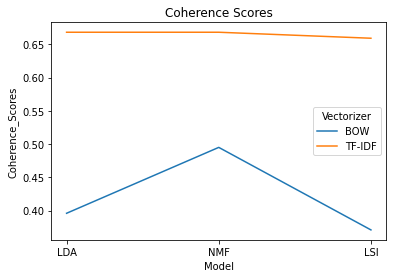

In [56]:
%matplotlib inline
import seaborn as sns
sns.lineplot(data=results,x="Model",y="Coherence_Scores",hue="Vectorizer").set(title = "Coherence Scores")
plt.show()